# Facility location assignment

Instructor: Frans de Ruiter

For assignment and data, see https://www.fransderuiter.com/JADS/

***

### Setup

In [1]:
import numpy as np
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt # optional for plotting
from matplotlib import cm # optional for plotting

### Read data
Here we load the distance table between the cities.

In [2]:
data_path = "https://www.fransderuiter.com/JADS/Facilitylocation/FacilityLocation.xlsx"
# Create pandas table
distances = pd.read_excel(data_path, sheet_name=0, header=0, skiprows=2, index_col=1)

# Show table
distances.head()

C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:292: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,Amsterdam,Antwerp,Athens,Barcelona,Berlin,Bern,Brussels,Calais,Cologne,...,Prague,Rome,Rotterdam,Strasbourg,Stuttgart,The Hague,Turin,Venice,Vienna,Zurich
Distance (km),,,,,,,,,,,,,,,,,,,,,
Amsterdam,NaN,0.0,160.0,3082.0,1639.0,649.0,875.0,209.0,385.0,280.0,...,973.0,1835.0,80.0,683.0,703.0,56.0,1264.0,1449.0,1196.0,861.0
Antwerp,NaN,160.0,0.0,2766.0,1465.0,723.0,704.0,46.0,211.0,237.0,...,870.0,1660.0,100.0,544.0,659.0,139.0,1090.0,1275.0,1180.0,687.0
Athens,NaN,3082.0,2766.0,0.0,3312.0,2552.0,2627.0,3021.0,2976.0,2562.0,...,2198.0,2551.0,2826.0,2581.0,2428.0,3061.0,2250.0,1995.0,1886.0,2449.0
Barcelona,NaN,1639.0,1465.0,3312.0,0.0,1899.0,913.0,1419.0,1399.0,1539.0,...,1679.0,1471.0,1565.0,1072.0,1263.0,1589.0,892.0,1327.0,1989.0,1036.0
Berlin,NaN,649.0,723.0,2552.0,1899.0,0.0,986.0,782.0,936.0,575.0,...,354.0,1573.0,697.0,801.0,636.0,712.0,1172.0,1108.0,666.0,863.0


Some data processing

In [3]:
#remove 1st column ('unnamed', because there is a comment in first column it was added in the database)
distances = distances.drop(distances.columns[0],1)

# Show table with removed column
distances.head()

,Amsterdam,Antwerp,Athens,Barcelona,Berlin,Bern,Brussels,Calais,Cologne,Copenhagen,...,Prague,Rome,Rotterdam,Strasbourg,Stuttgart,The Hague,Turin,Venice,Vienna,Zurich
Distance (km),,,,,,,,,,,,,,,,,,,,,
Amsterdam,0.0,160.0,3082.0,1639.0,649.0,875.0,209.0,385.0,280.0,904.0,...,973.0,1835.0,80.0,683.0,703.0,56.0,1264.0,1449.0,1196.0,861.0
Antwerp,160.0,0.0,2766.0,1465.0,723.0,704.0,46.0,211.0,237.0,861.0,...,870.0,1660.0,100.0,544.0,659.0,139.0,1090.0,1275.0,1180.0,687.0
Athens,3082.0,2766.0,0.0,3312.0,2552.0,2627.0,3021.0,2976.0,2562.0,3414.0,...,2198.0,2551.0,2826.0,2581.0,2428.0,3061.0,2250.0,1995.0,1886.0,2449.0
Barcelona,1639.0,1465.0,3312.0,0.0,1899.0,913.0,1419.0,1399.0,1539.0,2230.0,...,1679.0,1471.0,1565.0,1072.0,1263.0,1589.0,892.0,1327.0,1989.0,1036.0
Berlin,649.0,723.0,2552.0,1899.0,0.0,986.0,782.0,936.0,575.0,743.0,...,354.0,1573.0,697.0,801.0,636.0,712.0,1172.0,1108.0,666.0,863.0


In [4]:
## Show index names
cities = distances.columns
print(cities)

Index(['Amsterdam', 'Antwerp', 'Athens', 'Barcelona', 'Berlin', 'Bern',
       'Brussels', 'Calais', 'Cologne', 'Copenhagen', 'Edinburgh', 'Frankfurt',
       'Geneva', 'Genoa', 'Hamburg', 'Le Havre', 'Lisbon', 'London',
       'Luxembourg', 'Lyon', 'Madrid', 'Marseille', 'Milan', 'Munich',
       'Naples', 'Nice', 'Paris', 'Prague', 'Rome', 'Rotterdam', 'Strasbourg',
       'Stuttgart', 'The Hague', 'Turin', 'Venice', 'Vienna', 'Zurich'],
      dtype='object')


### Model parameters

In [5]:
# Fixed cost for opening a DC (same for each city)
fixed_cost = 100000

# demand equals 100 for each city
demand_per_city = 100

# Supply capacity of each city is 4000
M = 4000

# Create pandas dataframe with supply
city_params_dict = {'supply': M*np.ones(cities.size, int), 
                    'demand': demand_per_city*np.ones(cities.size, int), 
                    'fixed cost': fixed_cost*np.ones(cities.size, int)}
city_params = pd.DataFrame(data=city_params_dict, index = cities)
city_params.head()

,supply,demand,fixed cost
Amsterdam,4000,100,100000
Antwerp,4000,100,100000
Athens,4000,100,100000
Barcelona,4000,100,100000
Berlin,4000,100,100000


In [6]:
# extract the fixed costs for a city (in this case "Athens") as follows:
i_1 = 'Athens'
city_params.loc[i_1,'fixed cost']

100000

In [7]:
# extract the fixed costs for a city (in this case "Athens" to "Amsterdam") as follows:
i_1 = 'Athens'
j_1 = 'Amsterdam'
distances[i_1][j_1]

3082.0

### Model implementation

\begin{align*}
\begin{aligned}
  & \min_{x,y} & & \sum_{i=1}^N F_ix_i + \sum_{i=1}^N\sum_{j=1}^Nc_{ij}y_{ij}\\
  & \text{s.t.}
        & & \sum_{i=1}^N y_{ij} = d_{j} \qquad j=1,\dots,N\\
  & & & \sum_{j=1}^N y_{ij} \leq S_ix_i \qquad i=1,\dots,N\\
  & & & y_{ij} \geq 0 \qquad i=1,\dots,N,\ j=1,\dots,N\\
  & & & x_i \in \{0,1\} \qquad i=1,\dots,N.
\end{aligned}
\end{align*}
The first constraint $\sum_{i=1}^N y_{ij} = d_{j}$ ensures that the demand in the $i$-th city is met. The constraint $\sum_{j=1}^N y_{ij} \leq S_ix_i$ ensures that the total number of pallets leaving city $i$ is less than $0$ if there is no DC opened in city $i$ and less than $S_i$ if a DC is opened. Nonnegativity of the transport amount is guaranteed by the constraints $y_{ij} \geq 0$ and the binary nature (open or closed) of a DC by $x_i \in \{0,1\}$.

In [8]:
# Create model
m = ConcreteModel()

# Variables
m.locations = Var(cities, within=Binary)
m.shipments = Var(cities, cities, within = NonNegativeReals)

# Objective
m.value = Objective(
    expr=sum(m.shipments[i,j]*distances[i][j] for i in cities for j in cities)
    + sum(m.locations[i]*city_params.loc[i,'fixed cost'] for i in cities)
    , sense=minimize
             )

# Constraints on demand fulfillment
m.demand_fulfillment = ConstraintList()
for i in cities:
    m.demand_fulfillment.add(sum(m.shipments[j,i] for j in cities) == city_params.loc[i,'demand'])
    
# Constraints on supply only if DC is open
m.supply_restriction = ConstraintList()
for i in cities:
    m.supply_restriction.add(sum(m.shipments[i,j] for j in cities) <= m.locations[i]*city_params.loc[i,'supply'])

### Solve the model

In [9]:
# Optimize
solver = SolverFactory('cbc') # Take the cbc solver, glpk is very slow
status = solver.solve(m,tee=False,) # Set tee to True to see log of the solver

# Print the status of the solved mixed integer linear model once it is done
print("Status = %s \n" % status.solver.termination_condition)

Status = optimal 



### Show the solution


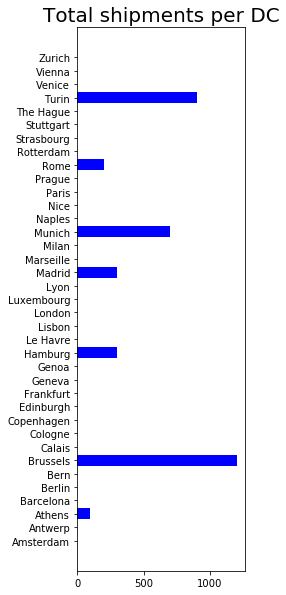

1684800.0

In [10]:
# Show some visualization via tables and/or plots to present your solution.
#TODO (optional): add more visualization, print your solution etc

# Make a vector with all the shipments
totalshipments = [sum(value(m.shipments[i,j]) for j in cities) for i in cities]

plt.figure(figsize=(3,10))

# make a horizontal bar plots
plt.barh(range(cities.size),totalshipments, color="blue",align="center") 

# Use city names on the vertical axis
plt.yticks(range(cities.size),cities,rotation=0)

# Set title and show plot
plt.title('Total shipments per DC',fontsize=20)
plt.show()

value(m.value)

---
## Additional visualization (not part of assignment)


Additional packages required. You might need to install these first to make the rest of the code work.

In [11]:
# mapping package
import folium
# geocoder
from geopy.geocoders import Nominatim
# limit geocode requests
from geopy.extra.rate_limiter import RateLimiter
# progress bar
from tqdm import tqdm
# namedtuple objects
from collections import namedtuple


First we find coordinates for each location. This process is called *geocoding*.

In [12]:
# an open source geocoder
geolocator = Nominatim(user_agent="specify_your_app_name_here")
# delay as to not overload the server. Note that a commercial one (like GoogleMaps API can handle much more)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# display progress bar
tqdm.pandas()

# Make a new dataframe
df_cities = pd.DataFrame({"name": cities})
df_cities.loc[
    df_cities.name == "Athens", "name"
] = "Athens, Greece"  # Our open source geocoder is not perfect.. Apparently there is an athens in the US it will use otherwise

# start geocoding
df_cities["location"] = df_cities["name"].progress_apply(geocode)
df_cities["lat"] = df_cities["location"].apply(lambda x: x.latitude)
df_cities["long"] = df_cities["location"].apply(lambda x: x.longitude)

# set index and display new dataframe with coordinates
df_cities.set_index("name", inplace=True)
df_cities.head()

  0%|                                                                                           | 0/37 [00:00<?, ?it/s]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Amsterdam',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\L

RateLimiter swallowed an error after 2 retries. Called with (*('Antwerp',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Barcelona',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code

 16%|█████████████▍                                                                     | 6/37 [00:59<05:28, 10.60s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Bern',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Local\C

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Brussels',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code,

 24%|████████████████████▏                                                              | 9/37 [01:36<05:27, 11.69s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Cologne',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Loca

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Copenhagen',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, cod

 32%|██████████████████████████▌                                                       | 12/37 [02:13<05:02, 12.11s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Frankfurt',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Lo

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Geneva',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, m

 41%|█████████████████████████████████▏                                                | 15/37 [02:50<04:28, 12.20s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Hamburg',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Loca

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Le Havre',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code,

 49%|███████████████████████████████████████▉                                          | 18/37 [03:26<03:52, 12.26s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('London',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Local

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Luxembourg',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, cod

 57%|██████████████████████████████████████████████▌                                   | 21/37 [04:03<03:16, 12.27s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Madrid',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Local

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Marseille',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code

 65%|█████████████████████████████████████████████████████▏                            | 24/37 [04:40<02:39, 12.27s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Munich',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Local

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Naples',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, m

 73%|███████████████████████████████████████████████████████████▊                      | 27/37 [05:17<02:02, 12.25s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Paris',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Local\

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Prague',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, m

 81%|██████████████████████████████████████████████████████████████████▍               | 30/37 [05:54<01:26, 12.33s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Rotterdam',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Lo

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Strasbourg',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, cod

 89%|█████████████████████████████████████████████████████████████████████████▏        | 33/37 [06:31<00:49, 12.29s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('The Hague',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Lo

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Turin',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, ms

 97%|███████████████████████████████████████████████████████████████████████████████▊  | 36/37 [07:08<00:12, 12.29s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Vienna',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\drt\AppData\Local

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Zurich',), **{}).
Traceback (most recent call last):
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\drt\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, m

AttributeError: 'NoneType' object has no attribute 'latitude'

A lof of the code below is taken from this blog: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e

In [ ]:
def get_arrows(locations, color="blue", size=3, n_arrows=3):

    """
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    """

    Point = namedtuple("Point", field_names=["lat", "lon"])

    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])

    # getting the rotation needed for our marker.
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90

    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1 : n_arrows + 1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1 : n_arrows + 1]

    arrows = []

    # creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(
            folium.RegularPolygonMarker(
                location=points,
                fill_color=color,
                number_of_sides=3,
                radius=size,
                rotation=rotation,
            ).add_to(some_map)
        )
    return arrows

def get_bearing(p1, p2):

    """
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    """

    long_diff = np.radians(p2.lon - p1.lon)

    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)

    x = np.sin(long_diff) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(long_diff))
    bearing = np.degrees(np.arctan2(x, y))

    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

### Produce the map

In [ ]:
some_map = folium.Map(tiles='OpenStreetMap')
cent_coord = [df_cities.loc["Amsterdam"]["lat"], df_cities.loc["Amsterdam"]["long"]]
bounds = []

for i in cities:
    for j in cities:
        if value(m.shipments[i, j]) != 0:
            origin = i
            destination = j
            if origin == 'Athens':
                origin = 'Athens, Greece'
            if destination == 'Athens':
                destination = 'Athens, Greece'
            origin_coord = [df_cities.loc[origin]["lat"], df_cities.loc[origin]["long"]]
            destination_coord = [df_cities.loc[destination]["lat"], df_cities.loc[destination]["long"]]
            bounds.append([origin_coord])
            folium.Circle(
                radius=25000,
                location=destination_coord,
                popup=i,
                color="#3186cc",
                fill=True,
                fill_color="#3186cc",
            ).add_to(some_map)
            folium.Circle(
                radius=80000,
                location=origin_coord,
                popup=j,
                color="crimson",
                fill=False,
                fill_color=None,
            ).add_to(some_map)
            # folium.Marker(location=da_coord, popup=da, icon=folium.Icon(color='red')).add_to(some_map)
            folium.PolyLine(locations=[origin_coord,destination_coord], color="grey").add_to(
                some_map
            )
            arrows = get_arrows(locations=[origin_coord, destination_coord], n_arrows=1)
            for arrow in arrows:
                arrow.add_to(some_map)
some_map.fit_bounds(
    bounds,
    padding_top_left=None,
    padding_bottom_right=None,
    padding=None,
    max_zoom=None,
)

folium.TileLayer('cartodbdark_matter').add_to(some_map)
folium.TileLayer('cartodbpositron').add_to(some_map)
# other mapping code (e.g. lines, markers etc.)
folium.LayerControl().add_to(some_map)

some_map.save("facilitylocation_solution.html")

In [ ]:
some_map

In [ ]:
# End of file